<h1><center>TOPIC MODELING</center></h1>

<img src="Modeling1.jpg">
Source: 
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [1]:
#import common libraries:
#------------------------
import pandas as pd #<- For managing the datasets
import re #<- For accessing a folder path
import numpy as np #<- For doing mathematical operation with arrays.
import matplotlib.pyplot as plt #<- To plot in python

#New libraries from the Natural Lenguage Toolkit (Human language data):
#----------------------------------------------------------------------
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize #<- For finding tokens (small divisions) from a large sample of text
from nltk.corpus import stopwords #<- For calling the know stopwords in english (e.g, articles, connectors)
from nltk.corpus import wordnet #<- For calling a lexical database in eglish with meanings, synonyms, antonyms, and more 
from nltk.stem import WordNetLemmatizer #<- For normalizing the words in a text, for example, different conjugations of a verb and its brings its simple form.

#New libraries from the sklearn the library for machine learning in python:
#--------------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #<- To vectorize our text into terms frequencies
from sklearn.decomposition import LatentDirichletAllocation #<- To classify our text into groups based on the vectors of frequencies

#New libraries for topic modelling:
#---------------------------------
import gensim #<- Topic modelling library 
import gensim.corpora as corpora #<- To create a corpus of our text

from wordcloud import WordCloud

from pprint import pprint

#New libraries for visualizing the topics in a topic model from a corpus (gensim):
#---------------------------------------------------------------------------------
import pyLDAvis #<- Visualization library
import pyLDAvis.gensim #<- Connecting with gensim

from wordcloud import WordCloud, STOPWORDS


#Extra libraries:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

## 1. Reading the dataset

In [2]:
Papers_pubmed = pd.read_csv('text.csv', encoding='latin', header=None, index_col=0)
Papers_pubmed.columns = ['Year', 'Title', 'Abstract']
print('Original size: ', str(Papers_pubmed.shape[0]))
Papers_pubmed = Papers_pubmed.dropna()
print('Size after removing empty rows: ', str(Papers_pubmed.shape[0]))
Papers_pubmed.head()

Original size:  1550
Size after removing empty rows:  1206


,Year,Title,Abstract
0,,,
1,1978,1H NMR of valine tRNA modified bases. Evidence...,Methyl and methylene protons of dihydrouridine...
2,1978,2'-Deoxy-2'-fluorouridine-5'-phosphate: an alt...,The substrate specificity of 2'-deoxy-2'-subst...
3,1978,360 MHz PMR studies on the involvement of the ...,"360 MHz measurements of chemical shifts, 3J1'-..."
4,1978,3'End labelling of RNA with 32P suitable for r...,"A new general method of labelling the 2',3'-di..."
5,1978,"5'-Halogeno-2',3'-cyclic sulphite isomers in t...",When uridine (Ia) is reacted with thionyl chlo...


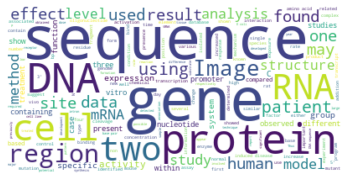

In [3]:
#What is this dataset about?

text = " ".join(review for review in Papers_pubmed.Abstract)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2. Clean the data, create the tokens and lemmas:

In [4]:
#Procedure to remove special characters such as hyphen and commas:
Papers_pubmed['Abstract_Cleaned'] = Papers_pubmed.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['Abstract'])),axis=1)
Papers_pubmed['Abstract_Cleaned'] = Papers_pubmed.apply(lambda row: (re.sub("\'", ' ', row['Abstract_Cleaned'])),axis=1)

#Procedure to remove tokenize (separate the words into a vector):
Papers_pubmed['Abstract_Cleaned'] = Papers_pubmed.apply(lambda row: (word_tokenize(row['Abstract_Cleaned'].upper())), axis = 1)
Papers_pubmed.head()

,Year,Title,Abstract,Abstract_Cleaned
0,,,,
1,1978,1H NMR of valine tRNA modified bases. Evidence...,Methyl and methylene protons of dihydrouridine...,"[METHYL, AND, METHYLENE, PROTONS, OF, DIHYDROU..."
2,1978,2'-Deoxy-2'-fluorouridine-5'-phosphate: an alt...,The substrate specificity of 2'-deoxy-2'-subst...,"[THE, SUBSTRATE, SPECIFICITY, OF, 2, DEOXY, 2,..."
3,1978,360 MHz PMR studies on the involvement of the ...,"360 MHz measurements of chemical shifts, 3J1'-...","[360, MHZ, MEASUREMENTS, OF, CHEMICAL, SHIFTS,..."
4,1978,3'End labelling of RNA with 32P suitable for r...,"A new general method of labelling the 2',3'-di...","[A, NEW, GENERAL, METHOD, OF, LABELLING, THE, ..."
5,1978,"5'-Halogeno-2',3'-cyclic sulphite isomers in t...",When uridine (Ia) is reacted with thionyl chlo...,"[WHEN, URIDINE, IA, IS, REACTED, WITH, THIONYL..."


In [13]:
#Update the stopwords
nltk.download('stopwords')
#Update wordnet
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tom/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
#Remove the stop words because they create noise:
#------------------------------------------------

#Download the stopwords in english (you can add stop words if they are very common in your dataset and don't add extra information)
stop_words = set([i.upper() for i in stopwords.words('english')])

#Remove the stopwords from our cleaned abstracts:
Papers_pubmed['Abstract_Cleaned'] = Papers_pubmed.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

Papers_pubmed.head()

,Year,Title,Abstract,Abstract_Cleaned
0,,,,
1,1978,1H NMR of valine tRNA modified bases. Evidence...,Methyl and methylene protons of dihydrouridine...,"[METHYL, METHYLENE, PROTONS, DIHYDROURIDINE, 1..."
2,1978,2'-Deoxy-2'-fluorouridine-5'-phosphate: an alt...,The substrate specificity of 2'-deoxy-2'-subst...,"[SUBSTRATE, SPECIFICITY, 2, DEOXY, 2, SUBSTITU..."
3,1978,360 MHz PMR studies on the involvement of the ...,"360 MHz measurements of chemical shifts, 3J1'-...","[360, MHZ, MEASUREMENTS, CHEMICAL, SHIFTS, 3J1..."
4,1978,3'End labelling of RNA with 32P suitable for r...,"A new general method of labelling the 2',3'-di...","[NEW, GENERAL, METHOD, LABELLING, 2, 3, DIOL, ..."
5,1978,"5'-Halogeno-2',3'-cyclic sulphite isomers in t...",When uridine (Ia) is reacted with thionyl chlo...,"[URIDINE, IA, REACTED, THIONYL, CHLORIDE, HEXA..."


In [15]:
#Lemmatize the abstracts: (With the network of words that come from the same roots you bring simple verbs pos ='v')
#You can lemmatize based on nouns, verbs,...: parts-of-speech (POS)
lmtzr = WordNetLemmatizer()

#A small example of the lematization:
print(lmtzr.lemmatize('eating', pos='v'))

#Lemmatizing our abstracts:
Papers_pubmed['Abstract_Cleaned'] = Papers_pubmed.apply(lambda row: ([lmtzr.lemmatize(w.lower(), pos='v').upper() for w in row['Abstract_Cleaned']]), axis=1)
Papers_pubmed.head()

eat


,Year,Title,Abstract,Abstract_Cleaned
0,,,,
1,1978,1H NMR of valine tRNA modified bases. Evidence...,Methyl and methylene protons of dihydrouridine...,"[METHYL, METHYLENE, PROTONS, DIHYDROURIDINE, 1..."
2,1978,2'-Deoxy-2'-fluorouridine-5'-phosphate: an alt...,The substrate specificity of 2'-deoxy-2'-subst...,"[SUBSTRATE, SPECIFICITY, 2, DEOXY, 2, SUBSTITU..."
3,1978,360 MHz PMR studies on the involvement of the ...,"360 MHz measurements of chemical shifts, 3J1'-...","[360, MHZ, MEASUREMENTS, CHEMICAL, SHIFT, 3J1,..."
4,1978,3'End labelling of RNA with 32P suitable for r...,"A new general method of labelling the 2',3'-di...","[NEW, GENERAL, METHOD, LABEL, 2, 3, DIOL, END,..."
5,1978,"5'-Halogeno-2',3'-cyclic sulphite isomers in t...",When uridine (Ia) is reacted with thionyl chlo...,"[URIDINE, IA, REACT, THIONYL, CHLORIDE, HEXAME..."


## 3. Create dictionary and corpora:

In [16]:
#Create an array from normalized word to integer ids from the cleaned data:
dictionary = corpora.Dictionary(Papers_pubmed['Abstract_Cleaned'])
print(dictionary[41])

#We save the cleaned abstracts in a small vector:
texts = Papers_pubmed['Abstract_Cleaned']

#Lets vectorize our abstracts!
#We have the ID's in our dictionary so for each abtracts we count the frequency of each token (zero 
#when it is not there). we have a vector of tuples with for each abstract (ID of the token and frequency):
corpus = [dictionary.doc2bow(text) for text in Papers_pubmed['Abstract_Cleaned']]
corpus

INVOLVE


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 4),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 6),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 2),
  (85, 3),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1)],
 [(15, 1

# 4. Let's start with Gensim and the classifier model:

In [ ]:
#We will use the Latent Dirichlet Allocation model (Widely used in topic modelling): 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, #This can be optimized
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
#Print the list of topics and see some of the words that are part of each group:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#Let's plot a wordcloud for each topic to understand also how are they build
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="white").fit_words(dict(lda_model.show_topic(t))))
    plt.axis("off")
    plt.title("Topic #" + str(t), size = 20)
    print("")
    plt.show()

In [ ]:
#Lets make it beautiful and appealing: Visualizations!
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

# Here the experts come and you decide together what are the topic main label based on the words!

In [ ]:
Main_Topic = list()
Main_Keywords = list()

for i in range(Papers_pubmed.shape[0]):
    Possible_topics_paper = dict(lda_model[corpus][i][0])
    Main_Topic.append(max(Possible_topics_paper, key=Possible_topics_paper.get))
    Key_words_topic = dict(lda_model.show_topic(Main_Topic[-1]))
    Main_Keywords.append(sorted(Key_words_topic, key=Key_words_topic.get, reverse=True)[:3])
Papers_pubmed['Main Topic'] = Main_Topic
Papers_pubmed['Main Topic Key words'] = Main_Keywords
Papers_pubmed